# Constructing a BPF function
Here we optimize the coefficients of the cosine approximation to a boxcar function, as a benchmark. (Of course, the correct answer here is the Fourier series of the boxcar)

In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

___

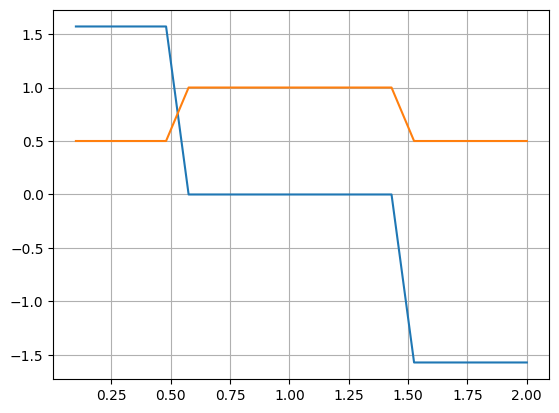

In [3]:
# Define target polynomial
w = torch.linspace(0.1,2,21) # for plotting
# polynomial_target = torch.tensor(np.zeros(len(w),dtype='complex128')) # double precision hits a snag with autodiff
polynomial_target = torch.tensor(np.zeros(len(w),dtype='complex64'))

_w1 = int(0.25*len(w))
_w2 = int(0.75*len(w))
polynomial_target[0:_w1] = 0.5*np.exp(1j*0.5*np.pi)*torch.ones(len(w[0:_w1]))
polynomial_target[_w1:_w2] = torch.ones(len(w[_w1:_w2])) # zero phase, flat passband target
polynomial_target[_w2:] = 0.5*np.exp(-1j*0.5*np.pi)*torch.ones(len(w[_w2:]))
plt.plot(w,np.angle(polynomial_target))
plt.plot(w,np.abs(polynomial_target))
plt.grid()

In [4]:
def computeCurve(parameters):
    # # L1,C1 = parameters.detach().numpy()
    # L1,C1 = parameters.clone().detach().numpy()

    M = [
        [torch.tensor(1-(w**2)*parameters[0]*parameters[1]), 1j*w*parameters[0]],
        [1j*w*parameters[1], torch.ones(len(w))]
    ]

    # This is basically the magnitude of (A/C)
    # polynomial_w = torch.tensor(1-(w**2)*L1*C1)/torch.tensor(w*C1)

    polynomial_w = M[0][0]/M[1][0] # for tensors, indexing like M[0,0] wont work
    # polynomial_w = sum(c * np.exp(1j*i*w) for i, c in enumerate(parameters))

    # NOTE: The current issue is with the polynomial computation.
    # Okay. Hardcoding the input impedance of a single tank
    # NOTE: This works, now shape this into a LC transfer function <---- Pickoff from here
    # polynomial_w = parameters[0]*(w**2) + 1j*parameters[1]*(w) - parameters[0]*(w**3)
    return polynomial_w

def computeError(parameters):
    polynomial_w = computeCurve(parameters)
    # print(f'DEBUG: polynomial_w = {polynomial_w}')
    # print(f'DEBUG: polynomial_target = {polynomial_target}')
    # loss_real = nn.MSELoss()(torch.real(polynomial_w), torch.real(polynomial_target))
    # loss_imag = nn.MSELoss()(torch.imag(polynomial_w), torch.real(polynomial_target))
    # loss = loss_real+loss_imag

    # loss = loss_real # testing
    loss = torch.sum(torch.abs(polynomial_w-polynomial_target)**2)
    return loss

C:\Users\DELL\AppData\Local\Temp\ipykernel_15904\1923126453.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [torch.tensor(1-(w**2)*parameters[0]*parameters[1]), 1j*w*parameters[0]],


Iteration 10 : (L1,C1) = tensor([0.9958, 0.5628], dtype=torch.float64, requires_grad=True); f = 547.2804565429688
Iteration 35 : (L1,C1) = tensor([0.9958, 0.7516], dtype=torch.float64, requires_grad=True); f = 317.300048828125
Iteration 60 : (L1,C1) = tensor([0.9958, 0.8772], dtype=torch.float64, requires_grad=True); f = 241.75936889648438
Iteration 85 : (L1,C1) = tensor([0.9958, 0.9733], dtype=torch.float64, requires_grad=True); f = 203.4153594970703


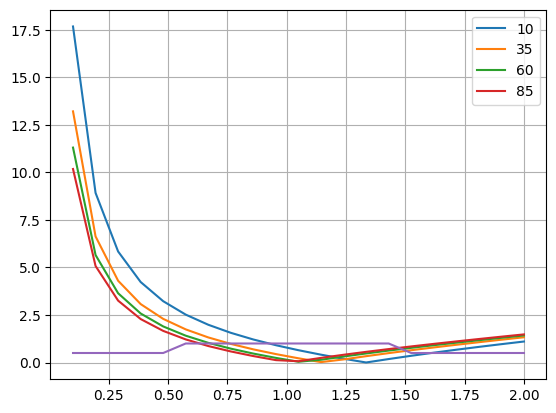

In [5]:

# =======================================================
parameters = torch.tensor(np.random.rand(2), requires_grad=True)

fig, axes = plt.subplots(); legend = []
optimizer = torch.optim.Adam([parameters], lr=0.01) # Adaptive algorithm, better
for i in range(100):
    optimizer.zero_grad()

    # Our desired loss function
    f = computeError(parameters) 
    f.backward()
    optimizer.step()

    # # Trying a simple one. Worker, so this is clearly a problem with our loss function
    # f = torch.sum(torch.abs(parameters)**2)
    # f.backward()
    # optimizer.step()

    if(i%25==10):
        print(f'Iteration {i} : (L1,C1) = {parameters}; f = {f.item()}')
        axes.plot(w,abs(computeCurve(parameters)).detach().numpy())
        legend.append(i)
# legend.append('Target')
axes.plot(w,abs(polynomial_target))
axes.legend(legend)
axes.grid('on')